# First Strategy: Moving left and right to climb the mountain

**Importing all the required libraries**

In [1]:
import sys
import gym
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

#Set plotting option
# %matplotlib inline
# plt.style.use('ggplot')
# np.set_printoptions(precision = 3, linewidth = 120)

**Creating the environment**

In [2]:
# Creating an environment
env = gym.make('MountainCar-v0')
env.reset()
# env.render()
# env.close()

array([-0.58776997,  0.        ])

In [3]:
print(env.observation_space)

Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)


In [4]:
print(env.observation_space.high)

[0.6  0.07]


Highest position is 0.6 and highest velocity is 0.07

In [5]:
print(env.observation_space.low)

[-1.2  -0.07]


Lowest position is -1.2 and lowest velocity is -0.07

In [6]:
print(env.action_space)

Discrete(3)


3 action space. Left, Right and Stop.

In [7]:
from IPython import display

In [8]:
TIME_LIMIT = 250

*Number of episode is 250*

In [9]:
env = gym.wrappers.TimeLimit(
        gym.envs.classic_control.MountainCarEnv(),
        max_episode_steps = TIME_LIMIT + 1)

obs = env.reset()
actions = {'left':0, 'stop':1, 'right':2}

**Left-Right action Strategy**

In [10]:
# plt.figure(figsize = (4,3))
display.clear_output(wait = True)
reward_list = []
episodes = 0
for t in range(TIME_LIMIT):
    # plt.gca().clear()
    if t > 50 and t < 100:
        obs, reward, done, info = env.step(actions['left'])
        reward_list.append(reward)
    else:
        obs, reward, done, info = env.step(actions['right'])
        reward_list.append(reward)
    # draw game image on display
    env.render()
    display.clear_output(wait = True)
#     display.display(plt.gcf())
    if done:
        display.clear_output(wait = True)
        print('Target achieved on {} epsiodes'.format(t))
        episode = t
        break
    else:
        print('You exceeded the Time limit.')
        display.clear_output(wait = True)
env.close()

Target achieved on 136 epsiodes


Text(0.5, 1.0, 'Average Reward vs Episodes')

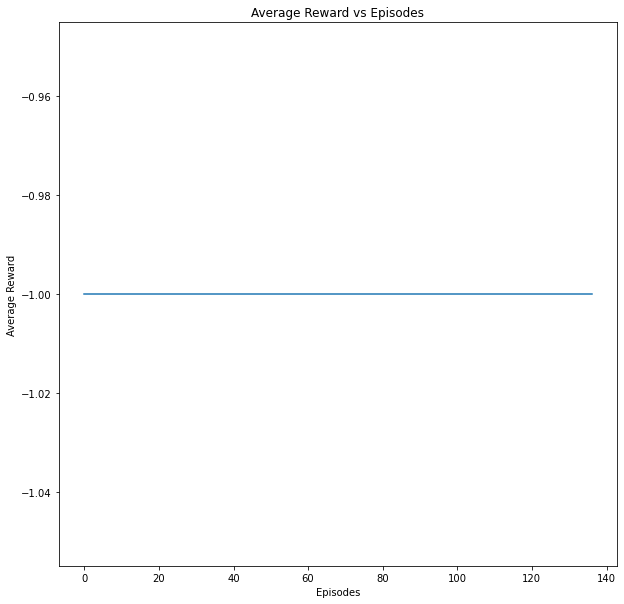

In [11]:
plt.figure(figsize = (10,10))
plt.plot(range(episode+1), reward_list)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.show()

# Second Strategy: Q-Learning

Source code for reference: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

In [12]:
def getHeight(x_position):
    return np.sin(3 * x_position) * 0.45 + 0.55

By refering the source code I got this height function.

In [13]:
def newReward(position):
    if position >= 0.5: # this is where the flag is 
        return 2
    else:
        return (position + 1.2)/1.8 - 1 # returning how far we are as a percentage of how far we can go.

This is the new reward function which I will be using instead of  default values -1 for poor performance and +1 for correct action. This reward function rewards the machine for going right and the value varies between -1 and 0.

In [14]:
# Define Q-learning function
def QLearning(env, learning, epsilon, min_eps, episodes):
    # Size of dicretized state space
    num_states = (env.observation_space.high - env.observation_space.low) * np.array([10,50])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initializing the Q-table with random values
    Q = np.random.uniform(low = -1, high = 0,
                         size = (num_states[0], num_states[1],
                                env.action_space.n))
    Qinit = np.copy(Q)
    
    # all the rewards per episode will be saved
    reward_list = []
    average_reward_list = []
    
    # making a shallow copy of epsilon
    cp_epsilon = epsilon
    
    # first time when car reaches the flag
    first = episodes + 1
    
    for i in range(episodes):
        done = False
        total_reward, reward = 0, 0
        state = env.reset()
        
        # discretizing the state and chosed less number of states so that Q-table updates faster meaning learning will be faster
        state_adjust = (state - env.observation_space.low) * np.array([10, 50])
        state_adjust = np.round(state_adjust, 0).astype(int)
        
        while done != True:
            if i >= (episodes - 5) or i < 5:
                env.render()
            
            if np.random.random() < 1 - epsilon: # Determing the next action based on reward
                action = np.argmax(Q[state_adjust[0], state_adjust[1]])
            else:
                action = np.random.randint(0, env.action_space.n)
                
            state2, reward, done, info = env.step(action) # getting next step and reward
            
            state2_adjust = (state2 - env.observation_space.low) * np.array([10, 50])
            state2_adjust = np.round(state2_adjust, 0).astype(int)
            
            row = np.array([state_adjust[0], state_adjust[1], action])
            
            # Updating the Q-table
            if done and state2[0] >= 0.5:
                print('Reached Flag on {} episode'.format(i+1))
                Q[state_adjust[0], state_adjust[1], action] = reward
            else:
                delta = learning * (newReward(state2[0]) + np.max(Q[state2_adjust[0], state2_adjust[1]]) - Q[state_adjust[0], state_adjust[1], action])
                Q[state_adjust[0], state_adjust[1], action] += delta
                
            if state2[0] >= 0.5 and i < first:
                first = i
                print('Reached flag for the first time on episode {}'.format(i+1))
                
            total_reward += newReward(state2[0])
            state_adjust = state2_adjust
            
        if epsilon > min_eps:
            epsilon *= cp_epsilon
            
        reward_list.append(total_reward)
        
        if (i+1) % 100 == 0:
            average_reward = np.mean(reward_list)
            average_reward_list.append(average_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:
            print('Episode {} average reward: {}'.format(i+1, average_reward))
            
    env.close()
    return average_reward_list, Q, Qinit

In [15]:
env = gym.make('MountainCar-v0')
env.reset()
rewards, Qpts, Qinit = QLearning(env, 0.2, 0.999, 0, 5000)

Episode 100 average reward: -124.90180673171376
Episode 200 average reward: -125.02083376402528
Episode 300 average reward: -125.14941736542215
Episode 400 average reward: -124.51337539988891
Episode 500 average reward: -124.3832117581215
Episode 600 average reward: -124.32312175883435
Episode 700 average reward: -124.2951702841689
Episode 800 average reward: -124.64361649240738
Episode 900 average reward: -125.1622547537139
Episode 1000 average reward: -123.44173184616835
Reached Flag on 1052 episode
Reached flag for the first time on episode 1052
Episode 1100 average reward: -123.23843053553485
Reached Flag on 1128 episode
Episode 1200 average reward: -122.75125329164229
Episode 1300 average reward: -124.1417587017729
Reached Flag on 1305 episode
Episode 1400 average reward: -124.40798558033117
Episode 1500 average reward: -123.28003295637029
Reached Flag on 1551 episode
Episode 1600 average reward: -122.70770636168513
Reached Flag on 1674 episode
Reached Flag on 1676 episode
Episode

Reached Flag on 2875 episode
Reached Flag on 2876 episode
Reached Flag on 2877 episode
Reached Flag on 2882 episode
Reached Flag on 2883 episode
Reached Flag on 2884 episode
Reached Flag on 2885 episode
Reached Flag on 2886 episode
Reached Flag on 2887 episode
Reached Flag on 2888 episode
Reached Flag on 2889 episode
Reached Flag on 2890 episode
Reached Flag on 2891 episode
Reached Flag on 2895 episode
Reached Flag on 2896 episode
Reached Flag on 2897 episode
Reached Flag on 2899 episode
Reached Flag on 2900 episode
Episode 2900 average reward: -111.37044439229831
Reached Flag on 2902 episode
Reached Flag on 2903 episode
Reached Flag on 2904 episode
Reached Flag on 2905 episode
Reached Flag on 2906 episode
Reached Flag on 2907 episode
Reached Flag on 2908 episode
Reached Flag on 2909 episode
Reached Flag on 2912 episode
Reached Flag on 2913 episode
Reached Flag on 2914 episode
Reached Flag on 2915 episode
Reached Flag on 2917 episode
Reached Flag on 2919 episode
Reached Flag on 2920 ep

Reached Flag on 3482 episode
Reached Flag on 3483 episode
Reached Flag on 3484 episode
Reached Flag on 3485 episode
Reached Flag on 3486 episode
Reached Flag on 3487 episode
Reached Flag on 3488 episode
Reached Flag on 3489 episode
Reached Flag on 3490 episode
Reached Flag on 3491 episode
Reached Flag on 3492 episode
Reached Flag on 3493 episode
Reached Flag on 3495 episode
Reached Flag on 3497 episode
Reached Flag on 3498 episode
Reached Flag on 3499 episode
Reached Flag on 3500 episode
Episode 3500 average reward: -110.84554260166587
Reached Flag on 3502 episode
Reached Flag on 3503 episode
Reached Flag on 3504 episode
Reached Flag on 3506 episode
Reached Flag on 3507 episode
Reached Flag on 3508 episode
Reached Flag on 3509 episode
Reached Flag on 3511 episode
Reached Flag on 3512 episode
Reached Flag on 3513 episode
Reached Flag on 3514 episode
Reached Flag on 3515 episode
Reached Flag on 3516 episode
Reached Flag on 3517 episode
Reached Flag on 3518 episode
Reached Flag on 3519 ep

Reached Flag on 3879 episode
Reached Flag on 3880 episode
Reached Flag on 3881 episode
Reached Flag on 3882 episode
Reached Flag on 3883 episode
Reached Flag on 3884 episode
Reached Flag on 3885 episode
Reached Flag on 3886 episode
Reached Flag on 3887 episode
Reached Flag on 3888 episode
Reached Flag on 3889 episode
Reached Flag on 3890 episode
Reached Flag on 3892 episode
Reached Flag on 3900 episode
Episode 3900 average reward: -106.48386301056182
Reached Flag on 3902 episode
Reached Flag on 3904 episode
Reached Flag on 3905 episode
Reached Flag on 3906 episode
Reached Flag on 3918 episode
Reached Flag on 3921 episode
Reached Flag on 3931 episode
Reached Flag on 3932 episode
Reached Flag on 3933 episode
Reached Flag on 3934 episode
Reached Flag on 3935 episode
Reached Flag on 3936 episode
Reached Flag on 3937 episode
Reached Flag on 3939 episode
Reached Flag on 3940 episode
Reached Flag on 3941 episode
Reached Flag on 3942 episode
Reached Flag on 3943 episode
Reached Flag on 3946 ep

Reached Flag on 4218 episode
Reached Flag on 4219 episode
Reached Flag on 4220 episode
Reached Flag on 4223 episode
Reached Flag on 4225 episode
Reached Flag on 4227 episode
Reached Flag on 4228 episode
Reached Flag on 4230 episode
Reached Flag on 4231 episode
Reached Flag on 4232 episode
Reached Flag on 4233 episode
Reached Flag on 4234 episode
Reached Flag on 4237 episode
Reached Flag on 4238 episode
Reached Flag on 4239 episode
Reached Flag on 4240 episode
Reached Flag on 4241 episode
Reached Flag on 4242 episode
Reached Flag on 4243 episode
Reached Flag on 4244 episode
Reached Flag on 4245 episode
Reached Flag on 4246 episode
Reached Flag on 4247 episode
Reached Flag on 4248 episode
Reached Flag on 4249 episode
Reached Flag on 4250 episode
Reached Flag on 4251 episode
Reached Flag on 4252 episode
Reached Flag on 4253 episode
Reached Flag on 4254 episode
Reached Flag on 4255 episode
Reached Flag on 4256 episode
Reached Flag on 4257 episode
Reached Flag on 4258 episode
Reached Flag o

Reached Flag on 4510 episode
Reached Flag on 4511 episode
Reached Flag on 4512 episode
Reached Flag on 4513 episode
Reached Flag on 4514 episode
Reached Flag on 4515 episode
Reached Flag on 4516 episode
Reached Flag on 4517 episode
Reached Flag on 4518 episode
Reached Flag on 4519 episode
Reached Flag on 4520 episode
Reached Flag on 4521 episode
Reached Flag on 4522 episode
Reached Flag on 4523 episode
Reached Flag on 4524 episode
Reached Flag on 4525 episode
Reached Flag on 4526 episode
Reached Flag on 4527 episode
Reached Flag on 4528 episode
Reached Flag on 4529 episode
Reached Flag on 4530 episode
Reached Flag on 4531 episode
Reached Flag on 4532 episode
Reached Flag on 4533 episode
Reached Flag on 4534 episode
Reached Flag on 4535 episode
Reached Flag on 4536 episode
Reached Flag on 4537 episode
Reached Flag on 4538 episode
Reached Flag on 4539 episode
Reached Flag on 4540 episode
Reached Flag on 4541 episode
Reached Flag on 4542 episode
Reached Flag on 4544 episode
Reached Flag o

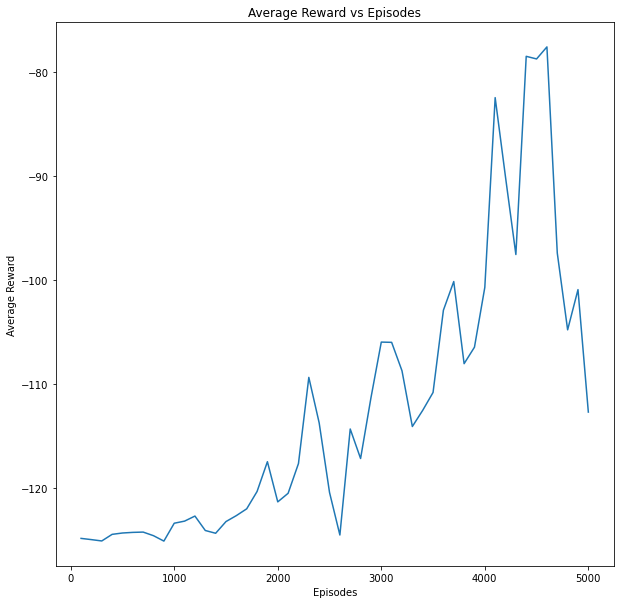

In [16]:
plt.figure(figsize = (10,10))
plt.plot(100 * (np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.show()

Initial action counts: [52 51 49]
Final action counts: [53 48 51]


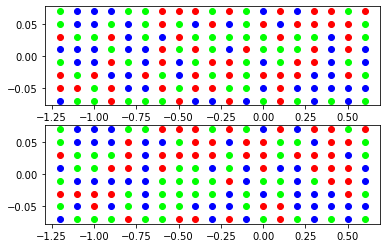

In [23]:
colors = ['lime', 'blue', 'red']
labels = ['left', 'neutral', 'right']
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
colorcount2 = np.array([0,0,0])
colorcount = np.array([0,0,0])
for i in range(19):
    for j in range(8):
        maxdex2 = np.argmax(Qinit[i][j])
        ax1.plot(i/10-1.2, j/50-0.07, 'o', color = colors[maxdex2])
        colorcount2[maxdex2] += 1
        maxdex = np.argmax(Qpts[i][j])
        ax2.plot(i/10-1.2, j/50-0.07, 'o', color = colors[maxdex])
        colorcount[maxdex] += 1
print('Initial action counts: {}'.format(colorcount))
print('Final action counts: {}'.format(colorcount2))
plt.show()

- lime is for left action
- blue is for doing nothing
- red is for right action